# Pairs Trading on NSE Equities (2019–2021)

### Aim
To design, implement, and evaluate cointegration-based pairs trading strategies on Indian equity markets (NSE) between 2019–2021, using methodologies inspired by both academic literature and industry practice.

### Objectives
1. **Baseline Replication** — Build a cointegration + z-score strategy (entry/exit thresholds, stop-loss, transaction costs) and evaluate its portfolio-level performance.
2. **Sector-Wise Insights** — Assess which NSE sectors (Auto, Pharma, IT, Banking, FMCG) are most conducive to pairs trading, replicating the approach of prior research (Sen, 2021).
3. **Graphical Matching Enhancement** — Apply a maximum-weight matching algorithm to avoid repeated stock exposure, compare risk-adjusted performance vs. the baseline.
4. **Robustness Checks** — Evaluate sensitivity to transaction costs, entry thresholds, and train/test splits (2019–20 train, 2021 test).
5. **Performance Reporting** — Provide yearly breakdowns, rolling Sharpe/drawdowns, per-pair contributions, and final professional tables/plots for inclusion in a research report.


# Evaluation and Adaptation of Pairs Trading Strategies in Indian Equities (2019–2021)

## Project Aim and Contribution

The aim of this project is to evaluate and adapt cointegration-based pairs trading strategies for Indian equity markets using NSE data from 2019-2021. Building on prior literature, we test both the standard top-N pair selection approach and the graphical matching method, while incorporating realistic frictions such as transaction costs and regime changes. The objective is not only to replicate published methodologies, but also to identify the conditions under which pairs trading can remain viable in the Indian context.

This study makes three contributions:  
1. It provides a direct replication of baseline and graphical matching strategies on recent Indian data, highlighting their limitations when applied without additional controls.  
2. It introduces refinements motivated by sector-specific evidence and walk-forward pair selection, which improve stability and mitigate overfitting.  
3. It compares risk-adjusted performance under different portfolio construction rules, transaction cost assumptions, and sectoral exposures.  

The findings show that while generic implementations often fail, a restricted and dynamically updated approach can deliver more consistent returns, offering a practical prototype for quantitative equity trading in emerging markets.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import yfinance as yf
from itertools import combinations
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 110
sns.set_context("talk")


In [3]:
# Ticker list (Yahoo Finance format)
tickers = [
    "TCS.NS", "INFY.NS", "WIPRO.NS",
    "HDFCBANK.NS", "ICICIBANK.NS", "SBIN.NS",
    "RELIANCE.NS", "HINDUNILVR.NS",
    "TATAMOTORS.NS", "MARUTI.NS",
    "SUNPHARMA.NS", "CIPLA.NS"
]

start_date = "2019-01-01"
end_date   = "2021-12-31"

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Decide which price field to use
if isinstance(data.columns, pd.MultiIndex):
    level0 = data.columns.get_level_values(0).unique().tolist()
    field = "Adj Close" if "Adj Close" in level0 else ("Close" if "Close" in level0 else None)
    if field is None:
        raise ValueError(f"No price field found. Available top-level fields: {level0}")

    prices = data[field].copy()
else:
    cols = data.columns.tolist()
    field = "Adj Close" if "Adj Close" in cols else ("Close" if "Close" in cols else None)
    if field is None:
        raise ValueError(f"No price field found. Available columns: {cols}")

    # Ensure column name(s) are tickers
    if len(tickers) == 1:
        prices = data[[field]].copy()
        prices.columns = tickers
    else:
        # If Yahoo returned a flat frame with tickers already as columns
        prices = data.copy()
        if field in prices.columns and len(prices.columns) == 1:
            prices.columns = tickers[:1]

# Clean panel
# Drop columns with too many NaNs (retain columns with at least 90% valid rows)
min_non_na = int(0.9 * len(prices))
prices = prices.dropna(axis=1, thresh=min_non_na)
prices = prices.dropna()

print(f"Field used: {field}")
print(f"Tickers requested: {len(tickers)} | Retained: {prices.shape[1]}")
print("Date range:", prices.index.min().date(), "→", prices.index.max().date())
print("Shape (days × tickers):", prices.shape)
prices.head()


Field used: Close
Tickers requested: 12 | Retained: 12
Date range: 2019-01-01 → 2021-12-30
Shape (days × tickers): (741, 12)


Ticker,CIPLA.NS,HDFCBANK.NS,HINDUNILVR.NS,ICICIBANK.NS,INFY.NS,MARUTI.NS,RELIANCE.NS,SBIN.NS,SUNPHARMA.NS,TATAMOTORS.NS,TCS.NS,WIPRO.NS
Date,,,,,,,,,,,,
2019-01-01,497.997406,485.339874,1626.637817,350.957001,568.239929,7004.461426,498.490570,276.445923,405.372101,170.909683,1717.571289,115.042717
2019-01-02,489.904572,480.911438,1611.735962,351.777161,571.657654,6808.712402,491.998230,271.186401,411.449646,166.081451,1736.076050,114.655304
2019-01-03,487.857544,477.138306,1615.167847,350.474609,571.743103,6748.849121,485.928284,268.602814,407.756348,163.618073,1714.998779,114.637695
2019-01-04,488.238403,478.414764,1609.116699,352.356079,564.822205,6777.469238,488.551880,274.646576,405.605896,168.446304,1694.147461,114.267883
2019-01-07,489.428528,479.137817,1612.052002,354.768097,573.921997,6896.960938,491.264496,273.400909,402.800842,172.781860,1713.148193,114.197456


In [4]:
import itertools

def ols_hedge_ratio(y: pd.Series, x: pd.Series):
    """
    OLS regression of y on x with intercept.
    Returns (beta, intercept, residuals).
    """
    x_ = sm.add_constant(x.values, has_constant='add')
    model = sm.OLS(y.values, x_).fit()
    beta = model.params[1]
    intercept = model.params[0]
    resid = y.values - (intercept + beta * x.values)
    resid = pd.Series(resid, index=y.index, name=f"resid_{y.name}_{x.name}")
    return beta, intercept, resid

def eg_cointegration(y: pd.Series, x: pd.Series):
    """
    Engle–Granger two-step (residual ADF) for a pair (y, x).
    Returns dict with tickers, adf_stat, pvalue, beta, intercept.
    """
    beta, intercept, resid = ols_hedge_ratio(y, x)
    adf_stat, pvalue, _, _, crit_vals, _ = ts.adfuller(resid.dropna(), autolag="AIC", maxlag=None, regression="c")
    return {
        "y": y.name,
        "x": x.name,
        "beta": beta,
        "intercept": intercept,
        "adf_stat": adf_stat,
        "pvalue": float(pvalue),
        "crit_1pct": crit_vals.get("1%"),
        "crit_5pct": crit_vals.get("5%"),
        "crit_10pct": crit_vals.get("10%")
    }

def scan_cointegration(prices: pd.DataFrame, min_obs: int = 250):
    """
    Scans all unordered pairs once (A,B) for cointegration y~x (y on x).
    Filters pairs with insufficient observations.
    Returns a DataFrame sorted by p-value ascending.
    """
    records = []
    cols = [c for c in prices.columns if prices[c].dropna().shape[0] >= min_obs]
    for a, b in itertools.combinations(cols, 2):
        y = prices[a].dropna()
        x = prices[b].dropna()
        idx = y.index.intersection(x.index)
        if len(idx) < min_obs:
            continue
        res = eg_cointegration(y.loc[idx], x.loc[idx])
        records.append(res)
    if not records:
        return pd.DataFrame(columns=["y","x","beta","intercept","adf_stat","pvalue","crit_1pct","crit_5pct","crit_10pct"])
    df = pd.DataFrame(records).sort_values("pvalue").reset_index(drop=True)
    return df


In [5]:
# Parameters for selection
PVALUE_CUTOFF = 0.05
TOP_N_PAIRS   = 6

cointegration_table = scan_cointegration(prices, min_obs=200)

# Filter by significance and take top N by p-value
sig_table = cointegration_table.query("pvalue <= @PVALUE_CUTOFF").copy()
sig_table = sig_table.sort_values("pvalue", ascending=True).head(TOP_N_PAIRS).reset_index(drop=True)

# Build list of chosen pairs as (y, x, beta, intercept)
chosen_pairs = [(row.y, row.x, row.beta, row.intercept) for _, row in sig_table.iterrows()]

print(f"Total tested pairs: {len(cointegration_table)}")
print(f"Significant pairs (p≤{PVALUE_CUTOFF:.2f}): {sig_table.shape[0]}")
display(
    sig_table[["y","x","beta","intercept","adf_stat","pvalue"]]
      .style.format({"beta":"{:.4f}","intercept":"{:.4f}","adf_stat":"{:.3f}","pvalue":"{:.4f}"})
      .set_caption("Selected Cointegrated Pairs (y ~ x)")
)


Total tested pairs: 66
Significant pairs (p≤0.05): 6


,y,x,beta,intercept,adf_stat,pvalue
0,INFY.NS,SUNPHARMA.NS,2.6266,-402.2768,-3.966,0.0016
1,SUNPHARMA.NS,WIPRO.NS,1.7420,212.4244,-3.778,0.0031
2,TATAMOTORS.NS,WIPRO.NS,1.3569,-21.0280,-3.694,0.0042
3,SUNPHARMA.NS,TCS.NS,0.2085,11.3815,-3.513,0.0077
4,INFY.NS,TCS.NS,0.5898,-473.3508,-3.453,0.0093
5,MARUTI.NS,TCS.NS,0.6813,4850.4773,-3.231,0.0182


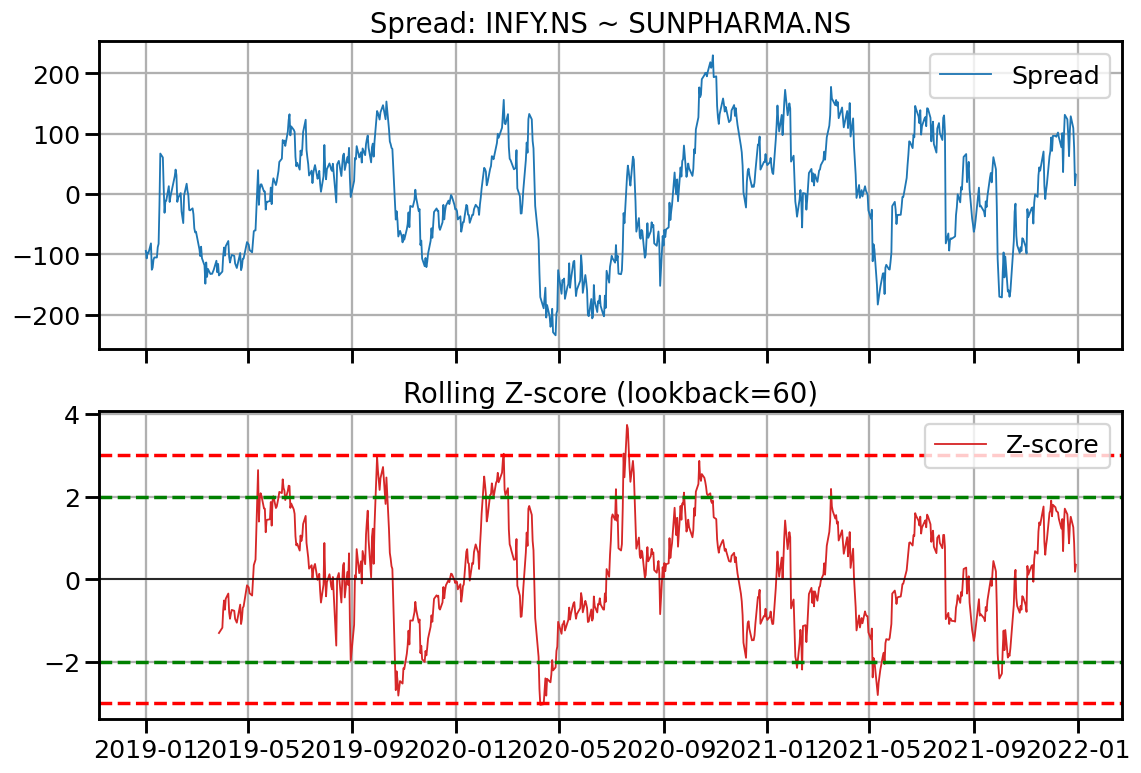

In [6]:
def compute_spread_zscore(y: pd.Series, x: pd.Series, beta: float, intercept: float, lookback: int = 60):
    """
    Compute spread and rolling z-score for a given pair.
    Spread = y - (intercept + beta * x)
    Z-score = (spread - mean) / std, over rolling lookback window.
    """
    spread = y - (intercept + beta * x)
    mean = spread.rolling(window=lookback).mean()
    std = spread.rolling(window=lookback).std()
    zscore = (spread - mean) / std
    return spread, zscore

# Example: compute for the first chosen pair
if chosen_pairs:
    y_ticker, x_ticker, beta, intercept = chosen_pairs[0]
    y = prices[y_ticker]
    x = prices[x_ticker]
    spread, zscore = compute_spread_zscore(y, x, beta, intercept, lookback=60)

    fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
    ax[0].plot(spread, label="Spread", lw=1.2)
    ax[0].set_title(f"Spread: {y_ticker} ~ {x_ticker}")
    ax[0].legend()

    ax[1].plot(zscore, label="Z-score", color="tab:red", lw=1.2)
    ax[1].axhline(0, color="black", lw=1)
    ax[1].axhline(2, color="green", ls="--")
    ax[1].axhline(-2, color="green", ls="--")
    ax[1].axhline(3, color="red", ls="--")
    ax[1].axhline(-3, color="red", ls="--")
    ax[1].set_title("Rolling Z-score (lookback=60)")
    ax[1].legend()
    plt.show()


Pair: INFY.NS ~ SUNPHARMA.NS
Trades: 11
Final P&L (₹): 47,134


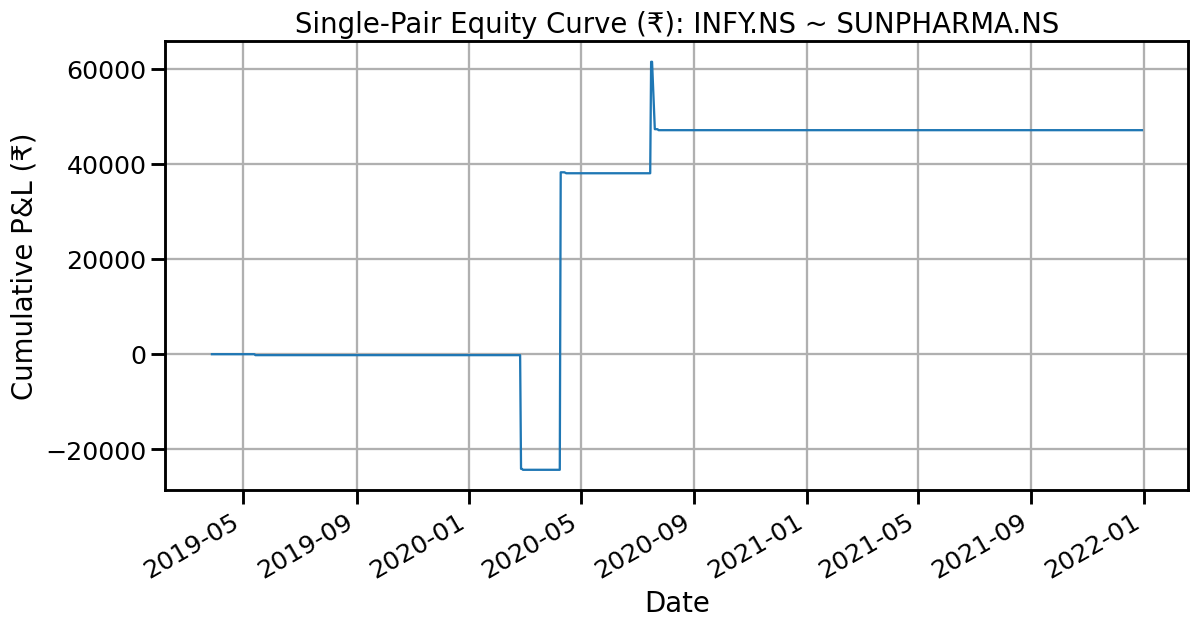

,time,side,action,z,y_px,x_px,pnl
0,2019-05-13,SHORT_SPREAD,ENTER,2.640442,614.934692,372.226196,NaN
1,2020-02-26,EXIT,EXIT,3.035678,686.791687,355.169037,-23721.705231
2,2020-02-27,SHORT_SPREAD,ENTER,2.168283,682.492432,368.249695,NaN
3,2020-04-09,EXIT,EXIT,-3.043189,558.251465,430.762085,62792.269435
4,2020-04-13,LONG_SPREAD,ENTER,-3.025403,559.260376,438.250336,NaN


In [7]:
from dataclasses import dataclass

@dataclass
class PairParams:
    entry_z: float = 2.0      # enter when |z| >= entry_z
    exit_z: float = 0.0       # exit when z reverts to this band
    stop_z: float = 3.0       # emergency stop if |z| >= stop_z
    lookback: int = 60        # z-score window (must match computation)
    alloc_rupees: float = 200_000.0  # notional per pair
    cost_bps: float = 10.0    # round-trip cost in basis points (e.g., 10 = 0.10%)

def backtest_pair(y: pd.Series, x: pd.Series, beta: float, intercept: float, params: PairParams):
    """
    State-machine backtest on a single pair using z-score thresholds.
    Positions:
      +1 = long spread  (long y, short beta*x)
      -1 = short spread (short y, long beta*x)
       0 = flat
    P&L is computed in capital mode (₹) with symmetric allocation to legs.
    """
    # Prepare spread & zscore
    spread, z = compute_spread_zscore(y, x, beta, intercept, params.lookback)
    z = z.dropna()
    y = y.loc[z.index]
    x = x.loc[z.index]

    # Position & accounting
    pos = 0   # current position: -1, 0, +1
    entry_price_y = entry_price_x = None
    equity = pd.Series(index=z.index, dtype=float)
    cash_pnl = 0.0
    trades = []

    # Leg notionals: split allocation equally across long/short legs
    half_alloc = params.alloc_rupees / 2.0

    # Per-leg transaction cost (applied on entry and exit): alloc * (bps/10000)
    rt_cost = params.cost_bps / 10_000.0

    for t in z.index:
        equity[t] = cash_pnl  # mark-to-cash between trades

        # Entry / Exit logic
        if pos == 0:
            if z.loc[t] <= -params.entry_z:
                # Long spread: long y (half_alloc), short beta*x (half_alloc)
                entry_price_y = y.loc[t]
                entry_price_x = x.loc[t]
                pos = +1
                cash_pnl -= params.alloc_rupees * rt_cost  # entry cost
                trades.append({"time": t, "side": "LONG_SPREAD", "action": "ENTER",
                               "z": z.loc[t], "y_px": entry_price_y, "x_px": entry_price_x})
            elif z.loc[t] >= params.entry_z:
                # Short spread: short y, long beta*x
                entry_price_y = y.loc[t]
                entry_price_x = x.loc[t]
                pos = -1
                cash_pnl -= params.alloc_rupees * rt_cost
                trades.append({"time": t, "side": "SHORT_SPREAD", "action": "ENTER",
                               "z": z.loc[t], "y_px": entry_price_y, "x_px": entry_price_x})

        else:
            # Exit conditions: mean reversion or stop
            exit_signal = (abs(z.loc[t]) <= params.exit_z) or (abs(z.loc[t]) >= params.stop_z)
            if exit_signal:
                # Realize P&L on both legs
                cur_y = y.loc[t]
                cur_x = x.loc[t]

                if pos == +1:
                    # Long y: P&L = (cur_y - entry_y) * qty_y; qty_y = half_alloc / entry_y
                    pnl_y = (cur_y - entry_price_y) * (half_alloc / entry_price_y)
                    # Short beta*x: entry is sell beta units notionally; qty_x = (half_alloc / entry_x)
                    pnl_x = -(cur_x - entry_price_x) * (half_alloc / entry_price_x) * beta
                elif pos == -1:
                    # Short y
                    pnl_y = -(cur_y - entry_price_y) * (half_alloc / entry_price_y)
                    # Long beta*x
                    pnl_x = (cur_x - entry_price_x) * (half_alloc / entry_price_x) * beta

                trade_pnl = pnl_y + pnl_x
                cash_pnl += trade_pnl
                cash_pnl -= params.alloc_rupees * rt_cost  # exit cost

                trades.append({"time": t, "side": "EXIT", "action": "EXIT",
                               "z": z.loc[t], "y_px": cur_y, "x_px": cur_x,
                               "pnl": trade_pnl})

                pos = 0
                entry_price_y = entry_price_x = None
                equity[t] = cash_pnl

    equity = equity.fillna(method="ffill").fillna(0.0)
    trades_df = pd.DataFrame(trades)

    results = {
        "equity": equity,        # cumulative P&L in ₹ for this pair
        "trades": trades_df,
        "zscore": z,
        "spread": spread.loc[z.index]
    }
    return results

# Example run for the first selected pair (uses current PVALUE/TopN selection)
if chosen_pairs:
    y_ticker, x_ticker, beta, intercept = chosen_pairs[0]
    params = PairParams(entry_z=2.0, exit_z=0.0, stop_z=3.0, lookback=60,
                        alloc_rupees=200_000.0, cost_bps=10.0)
    res_pair = backtest_pair(prices[y_ticker], prices[x_ticker], beta, intercept, params)

    print(f"Pair: {y_ticker} ~ {x_ticker}")
    print(f"Trades: {len(res_pair['trades'])}")
    print(f"Final P&L (₹): {res_pair['equity'].iloc[-1]:,.0f}")

    ax = res_pair["equity"].plot(lw=1.5)
    ax.set_title(f"Single-Pair Equity Curve (₹): {y_ticker} ~ {x_ticker}")
    ax.set_ylabel("Cumulative P&L (₹)")
    plt.show()

    display(res_pair["trades"].head())


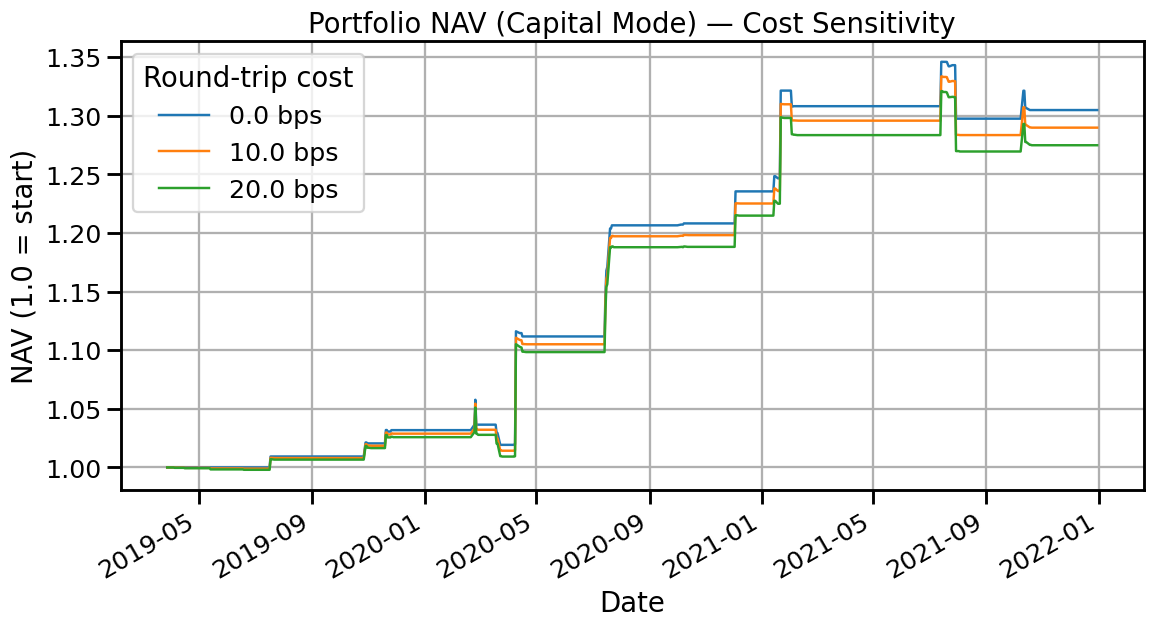

,Pairs,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD,Final_PnL_₹,Total_Alloc_₹
Cost_bps,,,,,,,,
0.000000,6,1.305,10.12%,8.40%,1.21,-3.64%,"365,694","1,200,000"
10.000000,6,1.290,9.66%,8.43%,1.16,-3.81%,"347,694","1,200,000"
20.000000,6,1.275,9.19%,8.46%,1.10,-3.98%,"329,694","1,200,000"


In [8]:
from math import sqrt

def max_drawdown(series: pd.Series):
    cummax = series.cummax()
    dd = (series - cummax) / cummax
    return dd.min(), dd

def run_portfolio(prices: pd.DataFrame, chosen_pairs, alloc_rupees_per_pair=200_000.0,
                  cost_bps_list=(0.0, 10.0, 20.0), entry_z=2.0, exit_z=0.0, stop_z=3.0, lookback=60):
    """
    Runs the pair backtest for each selected pair and aggregates into a portfolio.
    Returns dict with per-cost results: equity (₹), nav, stats table, and per-pair contributions.
    """
    results = {}
    if not chosen_pairs:
        raise ValueError("No chosen pairs to backtest.")

    # Precompute per-pair results at each cost level
    for cost in cost_bps_list:
        pair_equities = []
        pair_contrib = []
        per_pair = {}

        for (y_t, x_t, beta, intercept) in chosen_pairs:
            params = PairParams(entry_z=entry_z, exit_z=exit_z, stop_z=stop_z,
                                lookback=lookback, alloc_rupees=alloc_rupees_per_pair, cost_bps=cost)
            res = backtest_pair(prices[y_t], prices[x_t], beta, intercept, params)
            eq = res["equity"].copy()
            pair_equities.append(eq)
            per_pair[(y_t, x_t)] = res
            pair_contrib.append((y_t, x_t, eq.iloc[-1]))

        # Aggregate portfolio P&L by aligning on union of indices
        if not pair_equities:
            raise ValueError("No per-pair equities produced.")
        portfolio_equity = pd.concat(pair_equities, axis=1).fillna(method="ffill").fillna(0.0).sum(axis=1)
        portfolio_equity.name = f"equity_cost_{cost:.1f}bps"

        # Convert to NAV (starting at 1.0) using total committed capital
        total_alloc = alloc_rupees_per_pair * len(chosen_pairs)
        nav = 1.0 + (portfolio_equity / total_alloc)
        nav.name = f"nav_cost_{cost:.1f}bps"

        # Daily return series from NAV
        daily_ret = nav.pct_change().dropna()

        # Metrics
        ann_factor = 252
        yrs = (nav.index[-1] - nav.index[0]).days / 365.25
        cagr = (nav.iloc[-1] ** (1/yrs) - 1) if yrs > 0 else np.nan
        vol = daily_ret.std() * sqrt(ann_factor) if len(daily_ret) > 2 else np.nan
        sharpe = (daily_ret.mean() / daily_ret.std() * sqrt(ann_factor)) if daily_ret.std() > 0 else np.nan
        mdd_val, dd_curve = max_drawdown(nav)

        stats = pd.DataFrame({
            "Cost_bps": [cost],
            "Pairs": [len(chosen_pairs)],
            "Final_NAV": [nav.iloc[-1]],
            "CAGR": [cagr],
            "Vol_Ann": [vol],
            "Sharpe": [sharpe],
            "MaxDD": [mdd_val],
            "Final_PnL_₹": [portfolio_equity.iloc[-1]],
            "Total_Alloc_₹": [total_alloc]
        }).set_index("Cost_bps")

        contrib_df = pd.DataFrame(pair_contrib, columns=["y","x","final_pnl_₹"]).sort_values("final_pnl_₹", ascending=False)

        results[cost] = {
            "equity": portfolio_equity,
            "nav": nav,
            "drawdown": dd_curve,
            "daily_returns": daily_ret,
            "stats": stats,
            "per_pair": per_pair,
            "contrib": contrib_df
        }

    return results

# Run portfolio for the currently selected pairs and visualize NAVs
portfolio_results = run_portfolio(
    prices=prices,
    chosen_pairs=chosen_pairs,
    alloc_rupees_per_pair=200_000.0,
    cost_bps_list=(0.0, 10.0, 20.0),
    entry_z=2.0, exit_z=0.0, stop_z=3.0, lookback=60
)

ax = None
for cost, res in portfolio_results.items():
    ax = res["nav"].plot(lw=1.6, ax=ax, label=f"{cost:.1f} bps")
plt.title("Portfolio NAV (Capital Mode) — Cost Sensitivity")
plt.ylabel("NAV (1.0 = start)")
plt.legend(title="Round-trip cost")
plt.show()

# Consolidated stats table across costs
stats_table = pd.concat([res["stats"] for res in portfolio_results.values()], axis=0)
display(stats_table.style.format({
    "Final_NAV":"{:.3f}", "CAGR":"{:.2%}", "Vol_Ann":"{:.2%}", "Sharpe":"{:.2f}",
    "MaxDD":"{:.2%}", "Final_PnL_₹":"{:,.0f}", "Total_Alloc_₹":"{:,.0f}"
}).set_caption("Portfolio Performance — Cost Sensitivity"))


,Return,Vol_Ann,Sharpe,MaxDD
2019,2.88%,2.18%,1.80,-0.16%
2020,19.08%,11.22%,1.62,-3.81%
2021,5.28%,8.04%,0.69,-3.75%


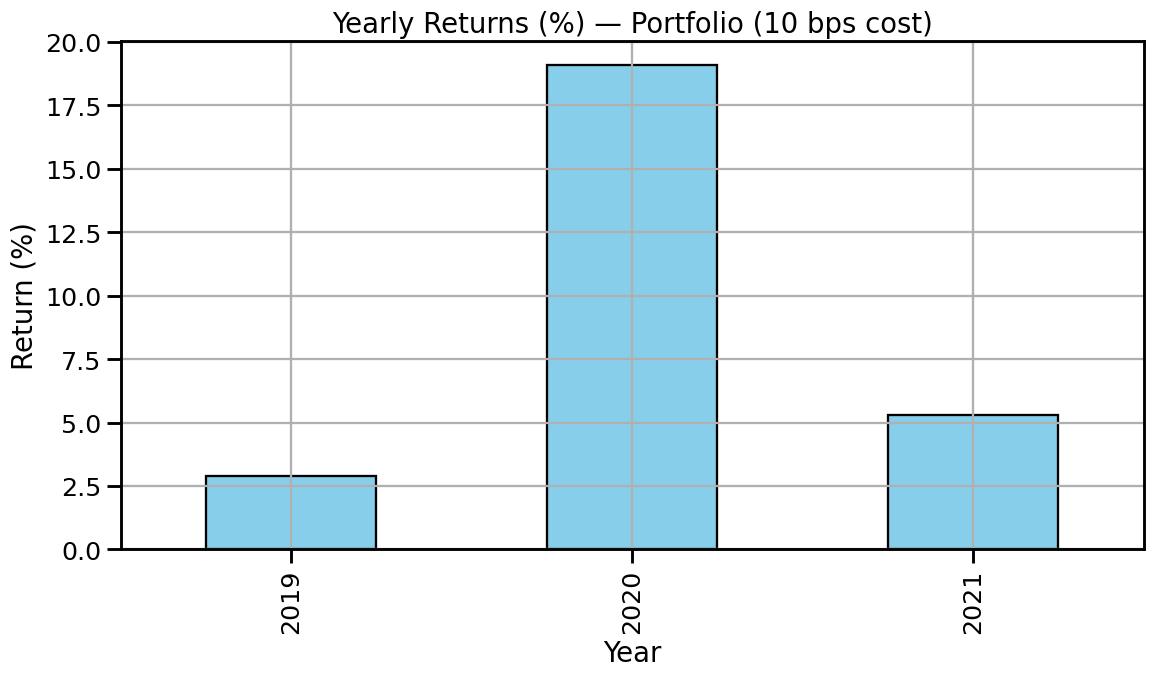

In [9]:
def yearly_performance(nav: pd.Series):
    """
    Computes calendar-year performance stats from NAV series.
    Returns DataFrame with yearly Return, Volatility, Sharpe, MaxDD.
    """
    df = pd.DataFrame({"nav": nav})
    df["ret"] = df["nav"].pct_change()

    years = {}
    for y, grp in df.groupby(df.index.year):
        if len(grp) < 50:  # skip incomplete years
            continue
        yr_ret = grp["nav"].iloc[-1] / grp["nav"].iloc[0] - 1
        vol = grp["ret"].std() * np.sqrt(252)
        sharpe = grp["ret"].mean() / grp["ret"].std() * np.sqrt(252) if grp["ret"].std() > 0 else np.nan
        mdd, _ = max_drawdown(grp["nav"])
        years[y] = {"Return": yr_ret, "Vol_Ann": vol, "Sharpe": sharpe, "MaxDD": mdd}
    return pd.DataFrame(years).T

# Example: yearly stats for portfolio at 10 bps cost
nav10 = portfolio_results[10.0]["nav"]
yearly_stats = yearly_performance(nav10)

display(yearly_stats.style.format({
    "Return":"{:.2%}", "Vol_Ann":"{:.2%}", "Sharpe":"{:.2f}", "MaxDD":"{:.2%}"
}).set_caption("Yearly Performance (10 bps cost)"))

# Plot yearly returns bar chart
(yearly_stats["Return"]*100).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Yearly Returns (%) — Portfolio (10 bps cost)")
plt.ylabel("Return (%)")
plt.xlabel("Year")
plt.show()


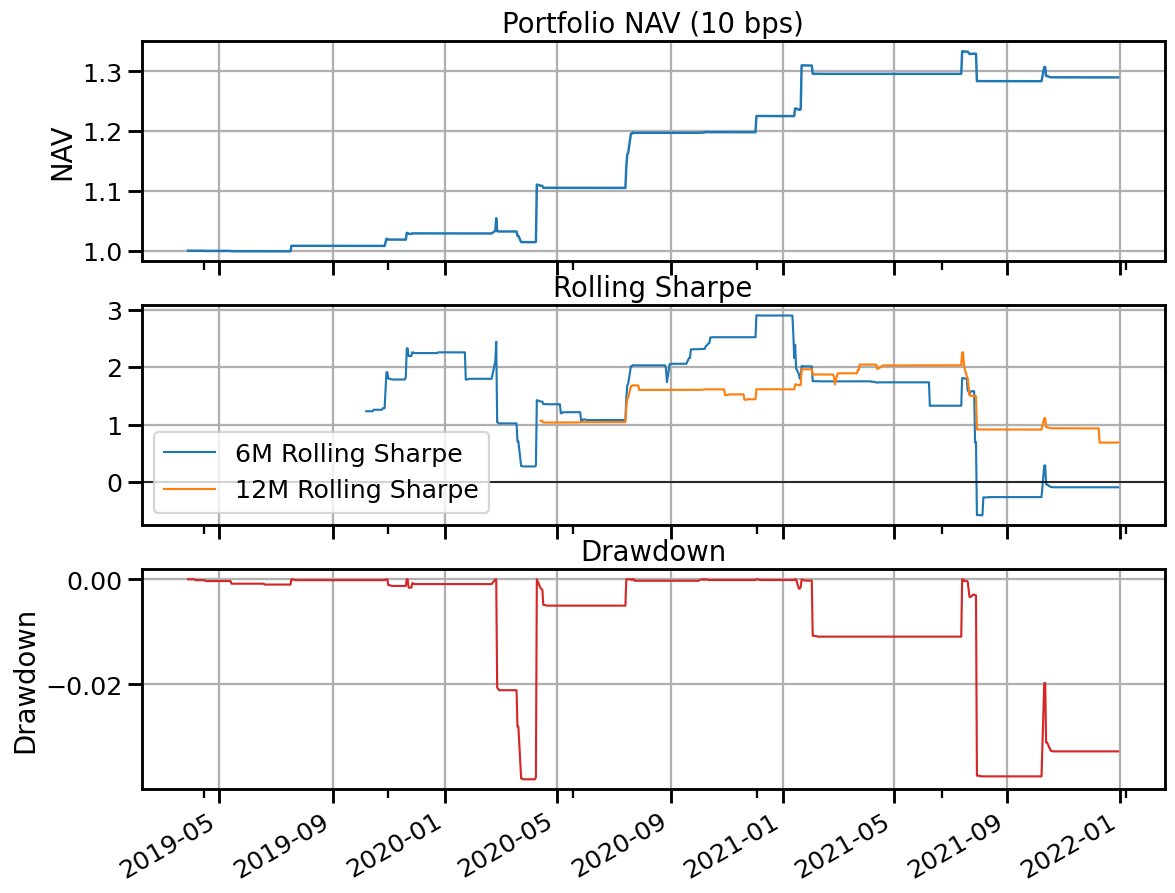

In [10]:
def rolling_sharpe(daily_ret: pd.Series, window_days: int = 126):  # ~6 months
    mu = daily_ret.rolling(window_days).mean()
    sd = daily_ret.rolling(window_days).std()
    rs = (mu / sd) * np.sqrt(252)
    return rs

def drawdown_curve(nav: pd.Series):
    roll_max = nav.cummax()
    dd = nav / roll_max - 1.0
    return dd

nav_ref = portfolio_results[10.0]["nav"]
dr_ref = portfolio_results[10.0]["daily_returns"]

rs_6m = rolling_sharpe(dr_ref, window_days=126)
rs_12m = rolling_sharpe(dr_ref, window_days=252)
dd_curve = drawdown_curve(nav_ref)

fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
nav_ref.plot(ax=ax[0], lw=1.6)
ax[0].set_title("Portfolio NAV (10 bps)")
ax[0].set_ylabel("NAV")

rs_6m.plot(ax=ax[1], lw=1.4, label="6M Rolling Sharpe")
rs_12m.plot(ax=ax[1], lw=1.4, label="12M Rolling Sharpe")
ax[1].axhline(0, color="black", lw=1)
ax[1].set_title("Rolling Sharpe")
ax[1].legend()

dd_curve.plot(ax=ax[2], lw=1.4, color="tab:red")
ax[2].set_title("Drawdown")
ax[2].set_ylabel("Drawdown")
ax[2].set_xlabel("")
plt.show()


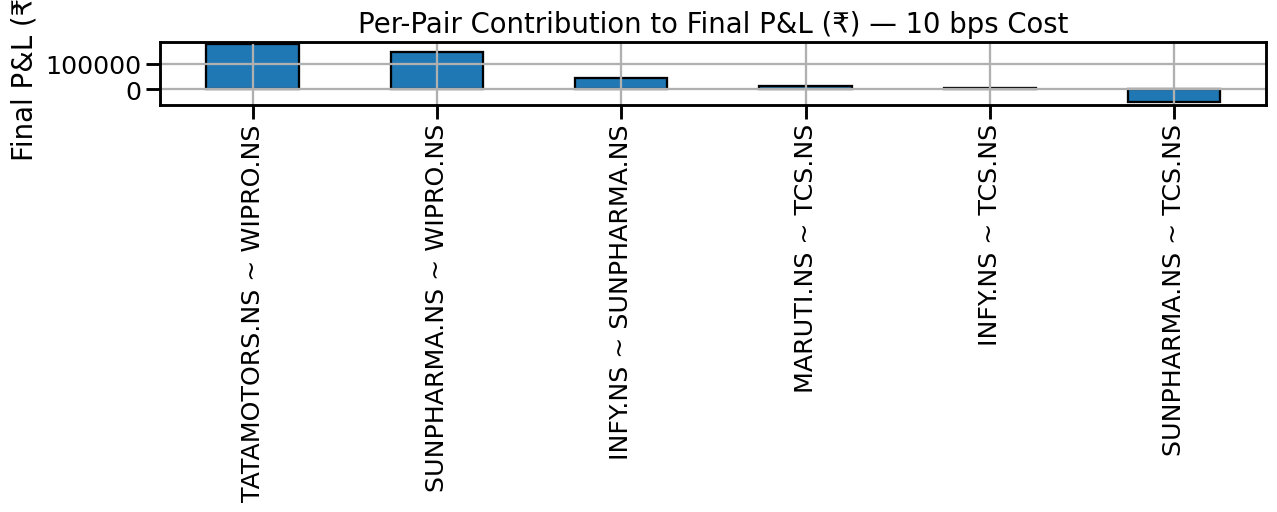

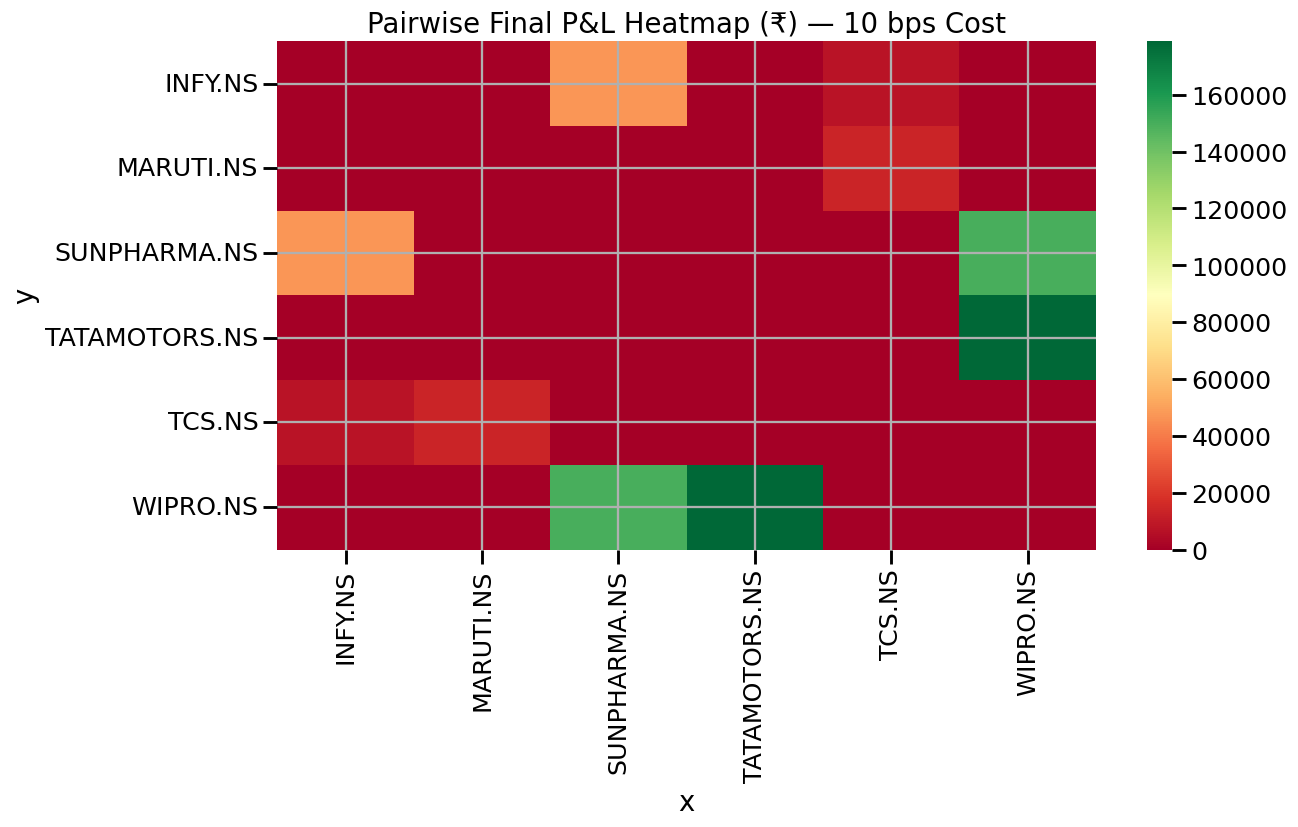

In [13]:
# Build a contribution table: final P&L by pair (₹), plus per-year contribution if available
contrib_df = portfolio_results[10.0]["contrib"].copy()  # final pnl by pair at 10 bps
contrib_df["pair"] = contrib_df["y"] + " ~ " + contrib_df["x"]

# Bar chart: final contribution per pair
contrib_bar = contrib_df.set_index("pair")["final_pnl_₹"].sort_values(ascending=False)
ax = contrib_bar.plot(kind="bar", figsize=(12,5), edgecolor="black")
ax.set_title("Per-Pair Contribution to Final P&L (₹) — 10 bps Cost")
ax.set_ylabel("Final P&L (₹)")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

# Create a square matrix over all tickers appearing in pairs
tick_set = sorted(set(contrib_df["y"]).union(set(contrib_df["x"])))
heat = pd.DataFrame(0.0, index=tick_set, columns=tick_set)

for _, r in contrib_df.iterrows():
    heat.loc[r["y"], r["x"]] = r["final_pnl_₹"]

# Symmetrize for visualization (max of (i,j) and (j,i))
for i in tick_set:
    for j in tick_set:
        if i != j:
            heat.loc[j, i] = max(heat.loc[i, j], heat.loc[j, i])

sns.heatmap(heat, cmap="RdYlGn", annot=False, fmt=".0f")
plt.title("Pairwise Final P&L Heatmap (₹) — 10 bps Cost")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [ ]:
def format_stats_table(results_dict):
    tbl = pd.concat([res["stats"] for res in results_dict.values()], axis=0)
    tbl = tbl[["Pairs","Total_Alloc_₹","Final_PnL_₹","Final_NAV","CAGR","Vol_Ann","Sharpe","MaxDD"]]
    return tbl

def single_pair_snapshot(res_pair_dict):
    eq = res_pair_dict["equity"]
    nav = 1.0 + eq / eq.abs().max() if eq.abs().max() != 0 else eq*0 + 1.0
    out = {
        "Trades": len(res_pair_dict["trades"]),
        "Final_PnL_₹": float(eq.iloc[-1]),
        "Final_NAV*": float(nav.iloc[-1])
    }
    return pd.Series(out)

# Assemble portfolio summary across costs
summary_tbl = format_stats_table(portfolio_results)
summary_tbl_fmt = summary_tbl.style.format({
    "Total_Alloc_₹":"{:,.0f}",
    "Final_PnL_₹":"{:,.0f}",
    "Final_NAV":"{:.3f}",
    "CAGR":"{:.2%}",
    "Vol_Ann":"{:.2%}",
    "Sharpe":"{:.2f}",
    "MaxDD":"{:.2%}"
}).set_caption("Portfolio Summary — Cost Sensitivity")

display(summary_tbl_fmt)

# Single-pair vs portfolio snapshot (using the first selected pair and 10 bps portfolio)
single_pair_stats = None
if chosen_pairs:
    y_t, x_t, beta, intercept = chosen_pairs[0]
    single_pair_stats = single_pair_snapshot(
        backtest_pair(prices[y_t], prices[x_t], beta, intercept,
                      PairParams(alloc_rupees=200_000.0, cost_bps=10.0))
    )
    single_pair_stats.name = f"{y_t} ~ {x_t}"

portfolio_core = portfolio_results[10.0]
yearly_stats_10bps = yearly_performance(portfolio_core["nav"])

# Print professional summary
print("—— Final Summary ——")
if single_pair_stats is not None:
    print("Single Pair (example, 10 bps):")
    display(single_pair_stats.to_frame("Value"))

print("Portfolio (10 bps):")
display(portfolio_core["stats"].style.format({
    "Final_NAV":"{:.3f}", "CAGR":"{:.2%}", "Vol_Ann":"{:.2%}",
    "Sharpe":"{:.2f}", "MaxDD":"{:.2%}", "Final_PnL_₹":"{:,.0f}", "Total_Alloc_₹":"{:,.0f}"
}))

print("Yearly Breakdown (10 bps):")
display(yearly_stats_10bps.style.format({
    "Return":"{:.2%}", "Vol_Ann":"{:.2%}", "Sharpe":"{:.2f}", "MaxDD":"{:.2%}"
}))

print("Notes:")
print("• Capital mode with equal ₹ allocation per pair; costs are round-trip bps.")
print("• Signals: |z|≥2 entry, exit at mean; stop at 3σ; z-score lookback 60d.")
print("• NAV scaled to total allocated capital across selected pairs.")


,Pairs,Total_Alloc_₹,Final_PnL_₹,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD
Cost_bps,,,,,,,,
0.000000,6,"1,200,000","365,695",1.305,10.12%,8.40%,1.21,-3.64%
10.000000,6,"1,200,000","347,695",1.290,9.66%,8.43%,1.16,-3.81%
20.000000,6,"1,200,000","329,695",1.275,9.19%,8.46%,1.10,-3.98%


—— Final Summary ——
Single Pair (example, 10 bps):


,Value
Trades,11.000000
Final_PnL_₹,47134.458880
Final_NAV*,1.766142


Portfolio (10 bps):


,Pairs,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD,Final_PnL_₹,Total_Alloc_₹
Cost_bps,,,,,,,,
10.000000,6,1.290,9.66%,8.43%,1.16,-3.81%,"347,695","1,200,000"


Yearly Breakdown (10 bps):


,Return,Vol_Ann,Sharpe,MaxDD
2019,2.88%,2.18%,1.80,-0.16%
2020,19.08%,11.22%,1.62,-3.81%
2021,5.28%,8.04%,0.69,-3.75%


Notes:
• Capital mode with equal ₹ allocation per pair; costs are round-trip bps.
• Signals: |z|≥2 entry, exit at mean; stop at 3σ; z-score lookback 60d.
• NAV scaled to total allocated capital across selected pairs.


In [ ]:
# Define sectors for the current universe (only tickers present in `prices` will be used)
sector_map = {
    "IT": ["TCS.NS", "INFY.NS", "WIPRO.NS"],
    "Banking": ["HDFCBANK.NS", "ICICIBANK.NS", "SBIN.NS"],
    "Auto": ["TATAMOTORS.NS", "MARUTI.NS"],
    "Pharma": ["SUNPHARMA.NS", "CIPLA.NS"],
    "Diversified": ["RELIANCE.NS", "HINDUNILVR.NS"]
}

p_cut = globals().get("PVALUE_CUTOFF", 0.10)
top_n_sector = 5
min_obs_sector = 150

sector_prices = {}
sector_tables = {}
sector_selected = {}

for sec, tlist in sector_map.items():
    use = [t for t in tlist if t in prices.columns]
    if len(use) < 2:
        continue
    panel = prices[use].dropna()
    if panel.shape[1] < 2 or len(panel) < min_obs_sector:
        continue
    sector_prices[sec] = panel
    tbl = scan_cointegration(panel, min_obs=min_obs_sector)
    sector_tables[sec] = tbl
    sel = (tbl.query("pvalue <= @p_cut")
              .sort_values("pvalue")
              .head(top_n_sector)
              .assign(sector=sec)
              .reset_index(drop=True))
    sector_selected[sec] = sel

# Combined view of selected pairs across sectors
if sector_selected:
    sector_selected_all = pd.concat(sector_selected.values(), ignore_index=True)
    display(
        sector_selected_all[["sector","y","x","beta","intercept","adf_stat","pvalue"]]
        .style.format({"beta":"{:.4f}","intercept":"{:.4f}","adf_stat":"{:.3f}","pvalue":"{:.4f}"})
        .set_caption(f"Sector-wise Selected Cointegrated Pairs (p ≤ {p_cut})")
    )
else:
    print("No sector produced significant cointegrated pairs with current settings.")

# Optional: quick per-sector summary counts
summary = []
for sec, tbl in sector_tables.items():
    n_sig = (tbl["pvalue"] <= p_cut).sum() if not tbl.empty else 0
    summary.append((sec, tbl.shape[0], n_sig))
if summary:
    summary_df = pd.DataFrame(summary, columns=["Sector","Pairs_Tested","Pairs_Significant_≤p"])
    display(summary_df.sort_values("Pairs_Significant_≤p", ascending=False).reset_index(drop=True))


,sector,y,x,beta,intercept,adf_stat,pvalue
0,IT,TCS.NS,INFY.NS,1.6343,859.7407,-3.616,0.0055
1,IT,TCS.NS,WIPRO.NS,7.9412,1035.2144,-2.905,0.0447


,Sector,Pairs_Tested,Pairs_Significant_≤p
0,IT,3,2
1,Banking,3,0
2,Auto,1,0
3,Pharma,1,0
4,Diversified,1,0


In [ ]:
sector_portfolios = {}
sector_stats = []

alloc_per_pair = 200_000.0
cost_bps = 10.0  # fixed at 10 bps for comparison
entry_z, exit_z, stop_z, lookback = 2.0, 0.0, 3.0, 60

for sec, tbl in sector_selected.items():
    chosen_pairs_sec = [(r.y, r.x, r.beta, r.intercept) for _, r in tbl.iterrows()]
    if not chosen_pairs_sec:
        continue

    results_sec = run_portfolio(
        prices=sector_prices[sec],
        chosen_pairs=chosen_pairs_sec,
        alloc_rupees_per_pair=alloc_per_pair,
        cost_bps_list=(cost_bps,),
        entry_z=entry_z,
        exit_z=exit_z,
        stop_z=stop_z,
        lookback=lookback
    )
    sector_portfolios[sec] = results_sec[cost_bps]
    stats_df = results_sec[cost_bps]["stats"].copy()
    stats_df["Sector"] = sec
    sector_stats.append(stats_df)

# Combine into one comparison table
if sector_stats:
    sector_stats_all = pd.concat(sector_stats)
    sector_stats_all = sector_stats_all.set_index("Sector")

    display(sector_stats_all[["Pairs","Total_Alloc_₹","Final_PnL_₹","Final_NAV","CAGR","Vol_Ann","Sharpe","MaxDD"]]
            .style.format({
                "Total_Alloc_₹":"{:,.0f}",
                "Final_PnL_₹":"{:,.0f}",
                "Final_NAV":"{:.3f}",
                "CAGR":"{:.2%}",
                "Vol_Ann":"{:.2%}",
                "Sharpe":"{:.2f}",
                "MaxDD":"{:.2%}"
            })
            .set_caption("Sector-wise Portfolio Performance (10 bps Cost)"))
else:
    print("No sector-level portfolios produced results.")


,Pairs,Total_Alloc_₹,Final_PnL_₹,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD
Sector,,,,,,,,
IT,2,"400,000","-729,029",-0.823,nan%,141.91%,-0.67,-194.12%


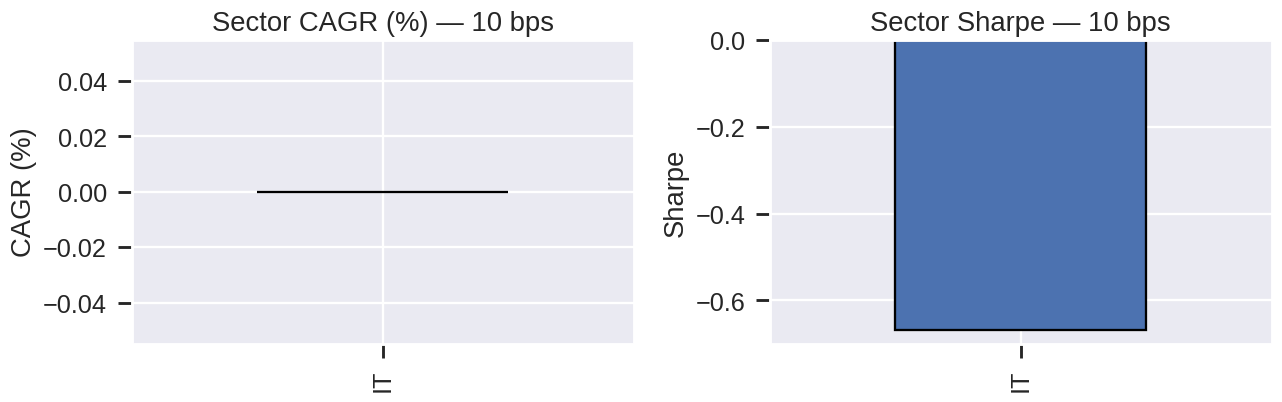

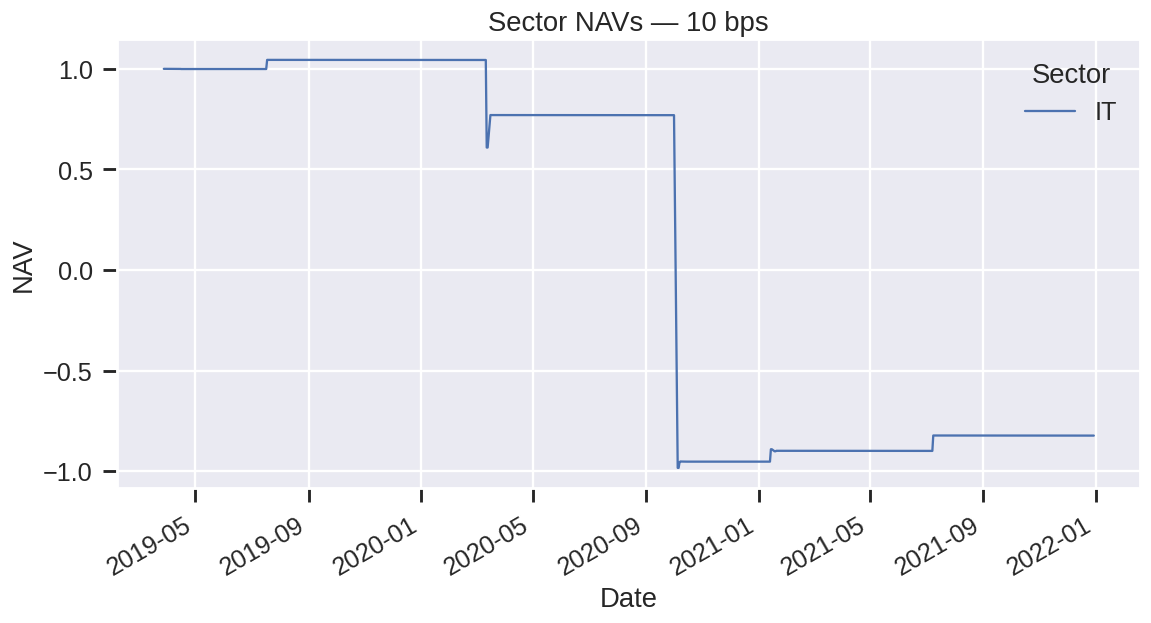

In [ ]:


if 'sector_stats_all' in globals() and not sector_stats_all.empty:
    # Bar charts for CAGR and Sharpe (10 bps)
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    (sector_stats_all['CAGR']*100).plot(kind='bar', ax=axes[0], edgecolor='black')
    axes[0].set_title("Sector CAGR (%) — 10 bps")
    axes[0].set_ylabel("CAGR (%)")
    axes[0].set_xlabel("")

    sector_stats_all['Sharpe'].plot(kind='bar', ax=axes[1], edgecolor='black')
    axes[1].set_title("Sector Sharpe — 10 bps")
    axes[1].set_ylabel("Sharpe")
    axes[1].set_xlabel("")

    plt.tight_layout()
    plt.show()

    # Small multiples: sector NAVs (10 bps)
    for sec, res in sector_portfolios.items():
        res['nav'].plot(lw=1.5, label=sec)
    plt.title("Sector NAVs — 10 bps")
    plt.ylabel("NAV")
    plt.legend(title="Sector")
    plt.show()
else:
    print("No sector results available. Consider loosening p-value/min_obs in Cell 13 and rerun.")


In [ ]:
import math
import networkx as nx

def build_matching_pairs(sig_table: pd.DataFrame, max_pairs: int = None, weight_col: str = None):
    """
    Constructs a maximum-weight matching from significant pairs.
    Each stock can appear in at most one pair.
    Edge weight defaults to -log(pvalue); alternative is |adf_stat|.
    Returns list of (y, x, beta, intercept) for matched pairs and a summary DataFrame.
    """
    if sig_table is None or sig_table.empty:
        return [], pd.DataFrame(columns=["y","x","beta","intercept","pvalue","adf_stat","weight"])

    tbl = sig_table.copy()
    if weight_col is None:
        # Default: stronger (smaller) p-values get larger weights
        tbl["weight"] = -np.log(tbl["pvalue"].clip(lower=1e-12))
    else:
        tbl["weight"] = tbl[weight_col].abs()

    G = nx.Graph()
    for _, r in tbl.iterrows():
        G.add_edge(r["y"], r["x"], weight=float(r["weight"]), beta=float(r["beta"]), intercept=float(r["intercept"]),
                   pvalue=float(r["pvalue"]), adf_stat=float(r["adf_stat"]))

    raw_matching = nx.algorithms.matching.max_weight_matching(G, maxcardinality=False, weight="weight")
    matched_edges = list(raw_matching)

    # Optionally limit to top-k by edge weight
    if max_pairs is not None and len(matched_edges) > max_pairs:
        # sort edges by weight
        matched_edges = sorted(matched_edges, key=lambda e: G[e[0]][e[1]]["weight"], reverse=True)[:max_pairs]

    rows = []
    matched_list = []
    for a, b in matched_edges:
        attr = G[a][b]
        # keep order consistent with earlier convention (y ~ x); arbitrary but stable
        y, x = a, b
        rows.append({
            "y": y, "x": x,
            "beta": attr["beta"], "intercept": attr["intercept"],
            "pvalue": attr["pvalue"], "adf_stat": attr["adf_stat"], "weight": attr["weight"]
        })
        matched_list.append((y, x, attr["beta"], attr["intercept"]))

    matched_df = pd.DataFrame(rows).sort_values("weight", ascending=False).reset_index(drop=True)
    return matched_list, matched_df

# Build matching from the globally selected significant table (sig_table)
# Fallback: if sig_table is empty, use cointegration_table up to a cutoff.
source_table = sig_table if ('sig_table' in globals() and not sig_table.empty) else cointegration_table.query("pvalue <= 0.10")

matching_pairs, matching_df = build_matching_pairs(source_table, max_pairs=len(chosen_pairs) if 'chosen_pairs' in globals() else None)

print(f"Baseline Top-N pairs: {len(chosen_pairs) if 'chosen_pairs' in globals() else 0}")
print(f"Matching (no-overlap) pairs: {len(matching_pairs)}")
display(matching_df[["y","x","beta","intercept","pvalue","adf_stat","weight"]]
        .style.format({"beta":"{:.4f}","intercept":"{:.4f}","pvalue":"{:.4f}","adf_stat":"{:.3f}","weight":"{:.3f}"})
        .set_caption("Maximum-Weight Matching — Selected Pairs"))


Baseline Top-N pairs: 6
Matching (no-overlap) pairs: 3


,y,x,beta,intercept,pvalue,adf_stat,weight
0,SUNPHARMA.NS,INFY.NS,2.6266,-402.2767,0.0016,-3.966,6.438
1,WIPRO.NS,TATAMOTORS.NS,1.3569,-21.0280,0.0042,-3.694,5.474
2,TCS.NS,MARUTI.NS,0.6813,4850.4771,0.0182,-3.231,4.004


,Pairs,Total_Alloc_₹,Final_PnL_₹,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD
Method,,,,,,,,
Baseline Top-N,6,"1,200,000","347,695",1.290,9.66%,8.43%,1.16,-3.81%
Graphical Matching,3,"600,000","-12,017",0.980,-0.73%,16.81%,0.03,-25.61%


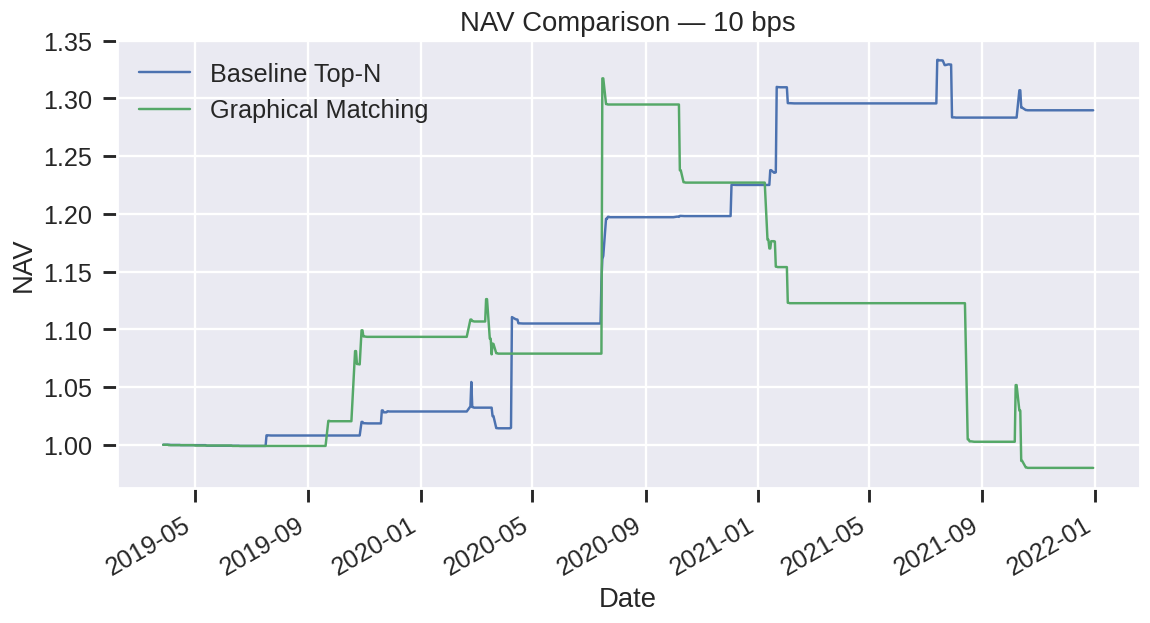

In [ ]:
# Choose a common cost for headline comparison
headline_cost = 10.0
alloc_per_pair = 200_000.0
params_common = dict(alloc_rupees_per_pair=alloc_per_pair,
                     cost_bps_list=(headline_cost,),
                     entry_z=2.0, exit_z=0.0, stop_z=3.0, lookback=60)

# Baseline Top-N (overlapping allowed)
baseline_res = None
if 'chosen_pairs' in globals() and chosen_pairs:
    baseline_res = run_portfolio(prices, chosen_pairs, **params_common)[headline_cost]

# Matching (no overlap)
matching_res = None
if matching_pairs:
    matching_res = run_portfolio(prices, matching_pairs, **params_common)[headline_cost]

# Assemble comparison table
rows = []
if baseline_res is not None:
    s = baseline_res["stats"].copy()
    s["Method"] = "Baseline Top-N"
    rows.append(s)
if matching_res is not None:
    s = matching_res["stats"].copy()
    s["Method"] = "Graphical Matching"
    rows.append(s)

if rows:
    comp = pd.concat(rows, axis=0).set_index("Method")
    comp = comp[["Pairs","Total_Alloc_₹","Final_PnL_₹","Final_NAV","CAGR","Vol_Ann","Sharpe","MaxDD"]]
    display(comp.style.format({
        "Total_Alloc_₹":"{:,.0f}",
        "Final_PnL_₹":"{:,.0f}",
        "Final_NAV":"{:.3f}",
        "CAGR":"{:.2%}",
        "Vol_Ann":"{:.2%}",
        "Sharpe":"{:.2f}",
        "MaxDD":"{:.2%}"
    }).set_caption(f"Baseline vs Graphical Matching — {headline_cost:.0f} bps"))

    # NAV overlay plot
    ax = None
    if baseline_res is not None:
        ax = baseline_res["nav"].plot(lw=1.6, label="Baseline Top-N")
    if matching_res is not None:
        matching_res["nav"].plot(lw=1.6, ax=ax, label="Graphical Matching")
    plt.title(f"NAV Comparison — {headline_cost:.0f} bps")
    plt.ylabel("NAV")
    plt.legend()
    plt.show()
else:
    print("No comparison available (check that both baseline and matching sets exist).")


,Baseline_TopN,Matching
SUNPHARMA.NS,3,1
TCS.NS,3,1
INFY.NS,2,1
WIPRO.NS,2,1
MARUTI.NS,1,1
TATAMOTORS.NS,1,1


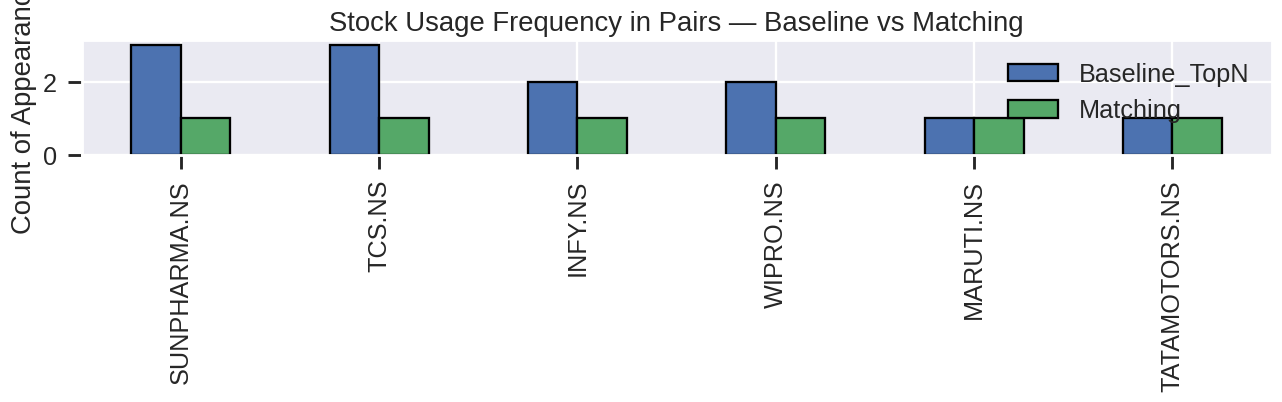

In [ ]:
from collections import Counter

def pair_overlap_counts(pairs):
    c = Counter()
    for y, x, _, _ in pairs:
        c[y] += 1
        c[x] += 1
    return pd.Series(c).sort_values(ascending=False)

baseline_counts = pair_overlap_counts(chosen_pairs) if 'chosen_pairs' in globals() and chosen_pairs else pd.Series(dtype=int)
matching_counts = pair_overlap_counts(matching_pairs) if matching_pairs else pd.Series(dtype=int)

conc_df = pd.DataFrame({
    "Baseline_TopN": baseline_counts,
    "Matching": matching_counts
}).fillna(0).astype(int).sort_values(["Baseline_TopN","Matching"], ascending=False)

if not conc_df.empty:
    display(conc_df)
    ax = conc_df.plot(kind="bar", figsize=(12,4), edgecolor="black")
    ax.set_title("Stock Usage Frequency in Pairs — Baseline vs Matching")
    ax.set_ylabel("Count of Appearances")
    ax.set_xlabel("")
    plt.tight_layout()
    plt.show()
else:
    print("No overlap diagnostics available (empty pair sets).")


Train/Test — Selected Pairs (frozen from train window):


,y,x,beta,intercept,adf_stat,pvalue
0,INFY.NS,TCS.NS,0.5274,-351.1747,-3.827,0.0026
1,MARUTI.NS,WIPRO.NS,21.5529,3556.6451,-3.058,0.0298
2,MARUTI.NS,TATAMOTORS.NS,15.1644,4054.7214,-3.057,0.0299
3,RELIANCE.NS,SUNPHARMA.NS,2.7208,-470.5330,-3.008,0.0342
4,CIPLA.NS,SUNPHARMA.NS,2.0796,-337.3347,-2.924,0.0426


Train/Test — Portfolio Stats (trade 2021 @10 bps):


,Pairs,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD,Final_PnL_₹,Total_Alloc_₹
Cost_bps,,,,,,,,
10.000000,5,1.246,33.91%,50.08%,0.81,-16.31%,"245,921","1,000,000"


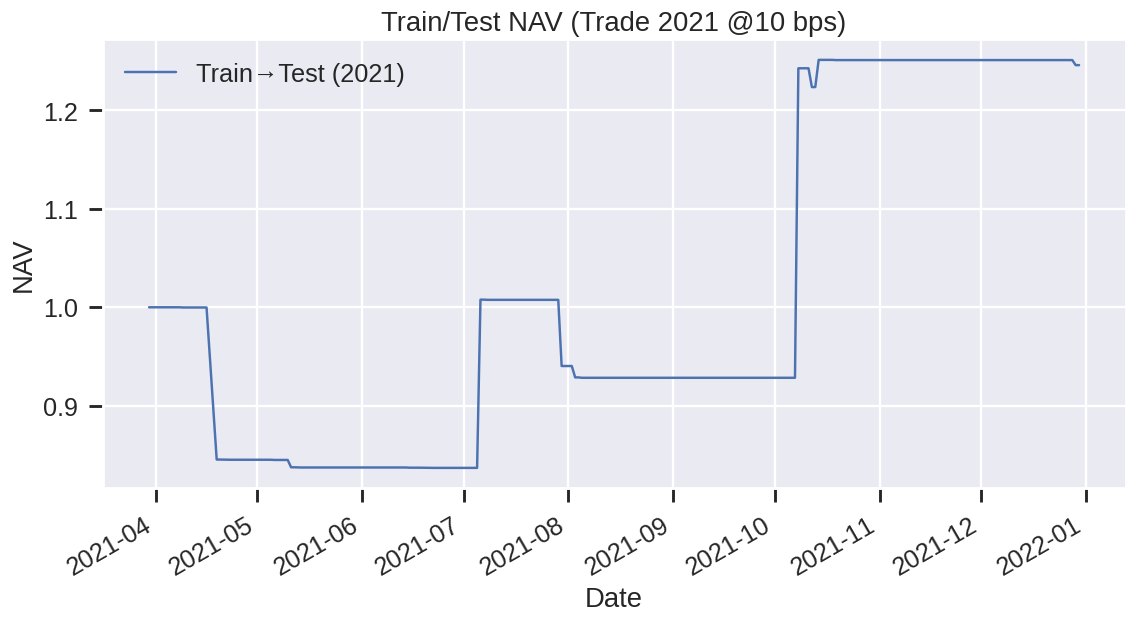

In [ ]:
def select_pairs_on_train(train_prices: pd.DataFrame, p_cut: float = 0.05, top_n: int = 6, min_obs: int = 200):
    tbl = scan_cointegration(train_prices, min_obs=min_obs)
    sel = (tbl.query("pvalue <= @p_cut")
             .sort_values("pvalue")
             .head(top_n)
             .reset_index(drop=True))
    pairs = [(r.y, r.x, r.beta, r.intercept) for _, r in sel.iterrows()]
    return pairs, sel

def run_train_test(full_prices: pd.DataFrame, train_start="2019-01-01", train_end="2020-12-31",
                   test_start="2021-01-01", test_end="2021-12-31",
                   p_cut=0.05, top_n=6, min_obs=200,
                   alloc_rupees_per_pair=200_000.0, cost_bps=10.0,
                   entry_z=2.0, exit_z=0.0, stop_z=3.0, lookback=60):
    train = full_prices.loc[train_start:train_end]
    test  = full_prices.loc[test_start:test_end]

    pairs, sel_tbl = select_pairs_on_train(train, p_cut=p_cut, top_n=top_n, min_obs=min_obs)
    if not pairs:
        return None, None, None

    res = run_portfolio(
        prices=test,
        chosen_pairs=pairs,
        alloc_rupees_per_pair=alloc_rupees_per_pair,
        cost_bps_list=(cost_bps,),
        entry_z=entry_z, exit_z=exit_z, stop_z=stop_z, lookback=lookback
    )[cost_bps]

    return pairs, sel_tbl, res

# Train on 2019–2020, trade 2021 at 10 bps
tt_pairs, tt_sel, tt_res = run_train_test(
    prices,
    p_cut=0.05, top_n=min(6, len(chosen_pairs) if 'chosen_pairs' in globals() else 6),
    min_obs=200, cost_bps=10.0
)

if tt_res is not None:
    print("Train/Test — Selected Pairs (frozen from train window):")
    display(tt_sel[["y","x","beta","intercept","adf_stat","pvalue"]]
            .style.format({"beta":"{:.4f}","intercept":"{:.4f}","adf_stat":"{:.3f}","pvalue":"{:.4f}"}))

    print("Train/Test — Portfolio Stats (trade 2021 @10 bps):")
    display(tt_res["stats"].style.format({
        "Final_NAV":"{:.3f}","CAGR":"{:.2%}","Vol_Ann":"{:.2%}","Sharpe":"{:.2f}",
        "MaxDD":"{:.2%}","Final_PnL_₹":"{:,.0f}","Total_Alloc_₹":"{:,.0f}"
    }))

    # Quick NAV view
    ax = tt_res["nav"].plot(lw=1.6, label="Train→Test (2021)")
    ax.set_ylabel("NAV")
    ax.set_title("Train/Test NAV (Trade 2021 @10 bps)")
    ax.legend()
    plt.show()
else:
    print("Train/Test produced no pairs under current thresholds.")


,Pairs,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD,Final_PnL_₹,Total_Alloc_₹
Cost_bps,,,,,,,,
0.000000,6,1.305,10.12%,8.40%,1.21,-3.64%,"365,695","1,200,000"
5.000000,6,1.297,9.89%,8.41%,1.19,-3.72%,"356,695","1,200,000"
10.000000,6,1.290,9.66%,8.43%,1.16,-3.81%,"347,695","1,200,000"
15.000000,6,1.282,9.43%,8.45%,1.13,-3.89%,"338,695","1,200,000"
20.000000,6,1.275,9.19%,8.46%,1.10,-3.98%,"329,695","1,200,000"
30.000000,6,1.260,8.73%,8.50%,1.05,-4.15%,"311,695","1,200,000"


,Pairs,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD,Final_PnL_₹,Total_Alloc_₹
Cost_bps,,,,,,,,
0.000000,3,0.999,-0.04%,16.65%,0.07,-24.70%,-617,"600,000"
5.000000,3,0.989,-0.38%,16.73%,0.05,-25.16%,"-6,317","600,000"
10.000000,3,0.980,-0.73%,16.81%,0.03,-25.61%,"-12,017","600,000"
15.000000,3,0.970,-1.08%,16.89%,0.01,-26.07%,"-17,717","600,000"
20.000000,3,0.961,-1.43%,16.97%,-0.01,-26.53%,"-23,417","600,000"
30.000000,3,0.942,-2.14%,17.14%,-0.05,-27.47%,"-34,817","600,000"


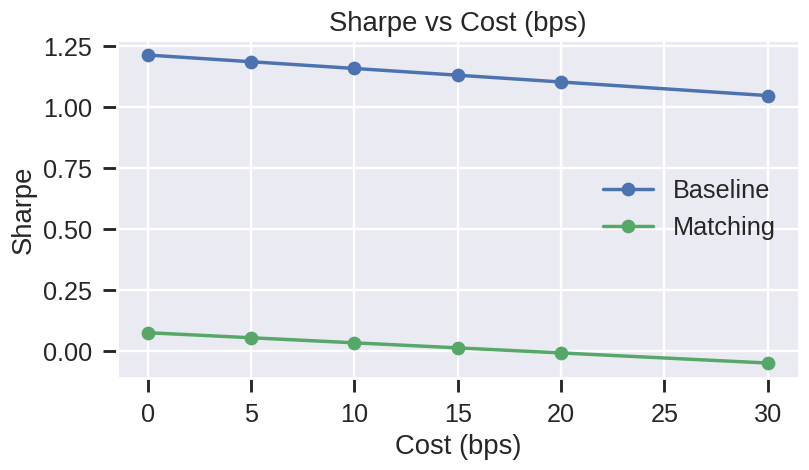

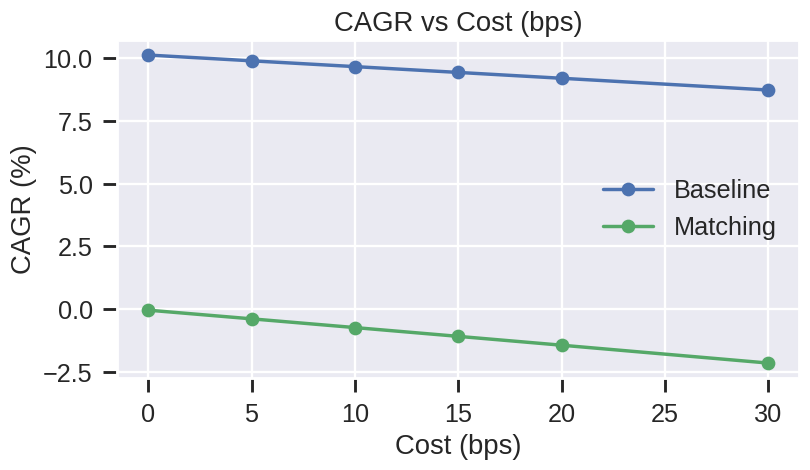

In [ ]:
def cost_sweep(prices: pd.DataFrame, pairs, costs=(0,5,10,15,20,30),
               alloc=200_000.0, entry_z=2.0, exit_z=0.0, stop_z=3.0, lookback=60):
    rows = []
    navs = {}
    for c in costs:
        res = run_portfolio(
            prices=prices,
            chosen_pairs=pairs,
            alloc_rupees_per_pair=alloc,
            cost_bps_list=(float(c),),
            entry_z=entry_z, exit_z=exit_z, stop_z=stop_z, lookback=lookback
        )[float(c)]
        s = res["stats"].copy()
        s["Cost_bps"] = float(c)
        rows.append(s.set_index("Cost_bps"))
        navs[c] = res["nav"]
    table = pd.concat(rows, axis=0).sort_index()
    return table, navs

costs = (0,5,10,15,20,30)
baseline_cost_tbl = None
matching_cost_tbl = None

if 'chosen_pairs' in globals() and chosen_pairs:
    baseline_cost_tbl, baseline_navs = cost_sweep(prices, chosen_pairs, costs=costs)

if 'matching_pairs' in globals() and matching_pairs:
    matching_cost_tbl, matching_navs = cost_sweep(prices, matching_pairs, costs=costs)

# Display tables
def _fmt(tbl):
    return tbl[["Pairs","Final_NAV","CAGR","Vol_Ann","Sharpe","MaxDD","Final_PnL_₹","Total_Alloc_₹"]].style.format({
        "Final_NAV":"{:.3f}","CAGR":"{:.2%}","Vol_Ann":"{:.2%}","Sharpe":"{:.2f}",
        "MaxDD":"{:.2%}","Final_PnL_₹":"{:,.0f}","Total_Alloc_₹":"{:,.0f}"
    })

if baseline_cost_tbl is not None:
    display(_fmt(baseline_cost_tbl).set_caption("Baseline — Cost Sensitivity"))
if matching_cost_tbl is not None:
    display(_fmt(matching_cost_tbl).set_caption("Graphical Matching — Cost Sensitivity"))

# Sharpe vs Cost plot
fig, ax = plt.subplots(figsize=(8,4))
if baseline_cost_tbl is not None:
    ax.plot(baseline_cost_tbl.index, baseline_cost_tbl["Sharpe"], marker="o", label="Baseline")
if matching_cost_tbl is not None:
    ax.plot(matching_cost_tbl.index, matching_cost_tbl["Sharpe"], marker="o", label="Matching")
ax.set_title("Sharpe vs Cost (bps)")
ax.set_xlabel("Cost (bps)")
ax.set_ylabel("Sharpe")
ax.legend()
plt.show()

# CAGR vs Cost plot
fig, ax = plt.subplots(figsize=(8,4))
if baseline_cost_tbl is not None:
    ax.plot(baseline_cost_tbl.index*1.0, baseline_cost_tbl["CAGR"]*100, marker="o", label="Baseline")
if matching_cost_tbl is not None:
    ax.plot(matching_cost_tbl.index*1.0, matching_cost_tbl["CAGR"]*100, marker="o", label="Matching")
ax.set_title("CAGR vs Cost (bps)")
ax.set_xlabel("Cost (bps)")
ax.set_ylabel("CAGR (%)")
ax.legend()
plt.show()


Headline Method: Graphical Matching @ 10 bps


,Pairs,Final_NAV,CAGR,Vol_Ann,Sharpe,MaxDD,Final_PnL_₹,Total_Alloc_₹
Cost_bps,,,,,,,,
10.000000,3,0.980,-0.73%,16.81%,0.03,-25.61%,"-12,017","600,000"


,Return,Vol_Ann,Sharpe,MaxDD
2019,9.35%,8.21%,1.54,-1.07%
2020,12.22%,23.06%,0.60,-6.85%
2021,-20.14%,13.68%,-1.60,-20.14%


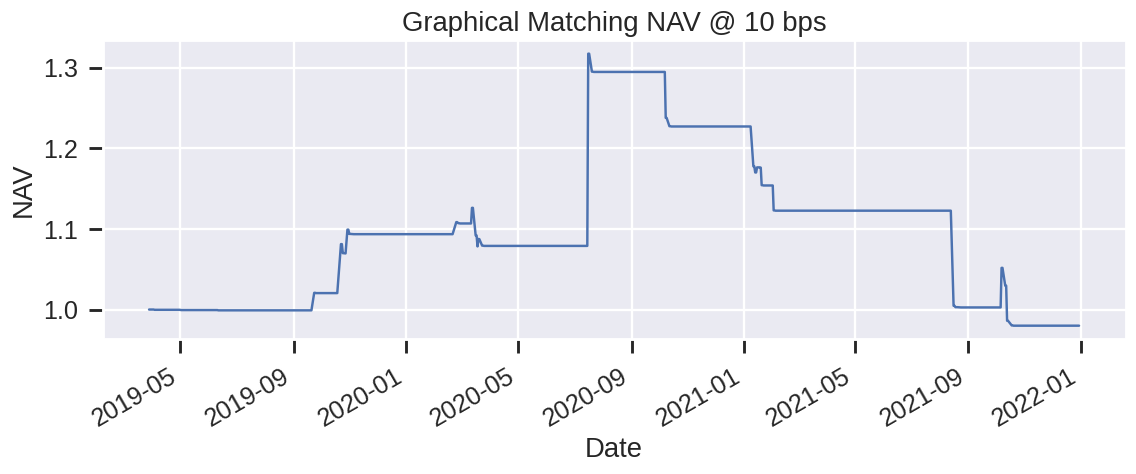

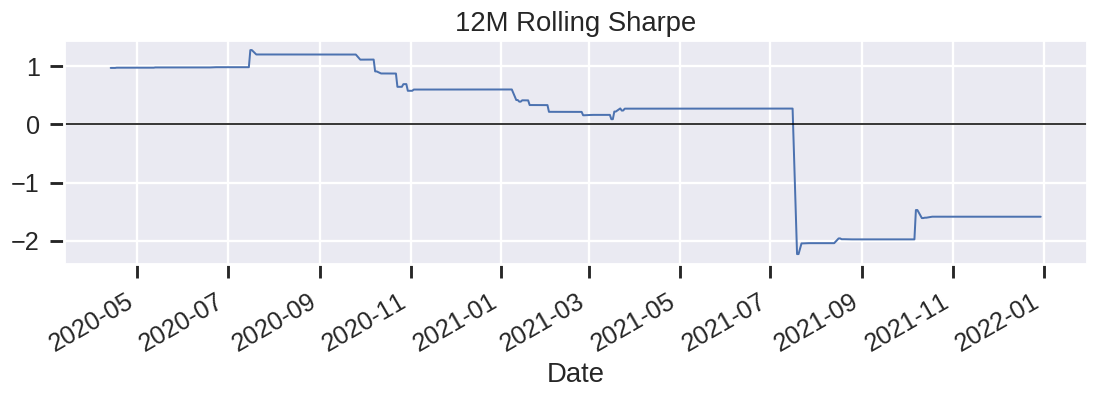

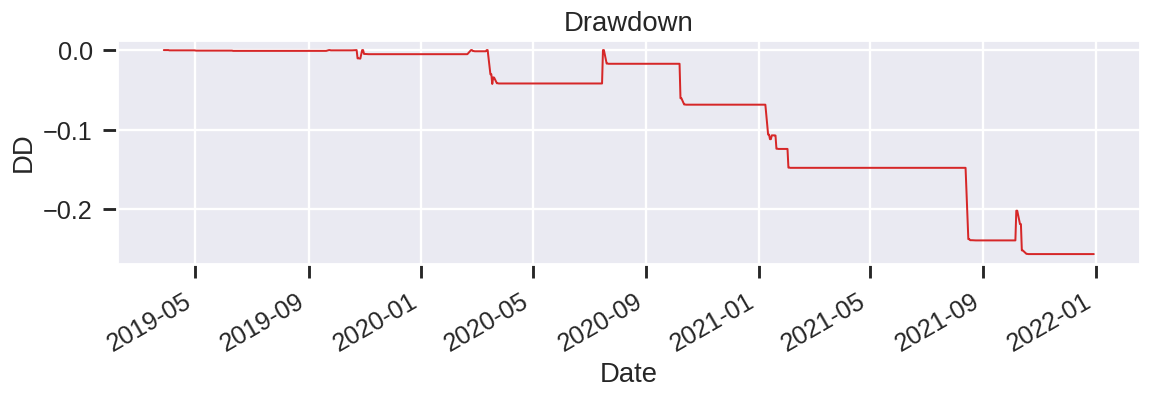

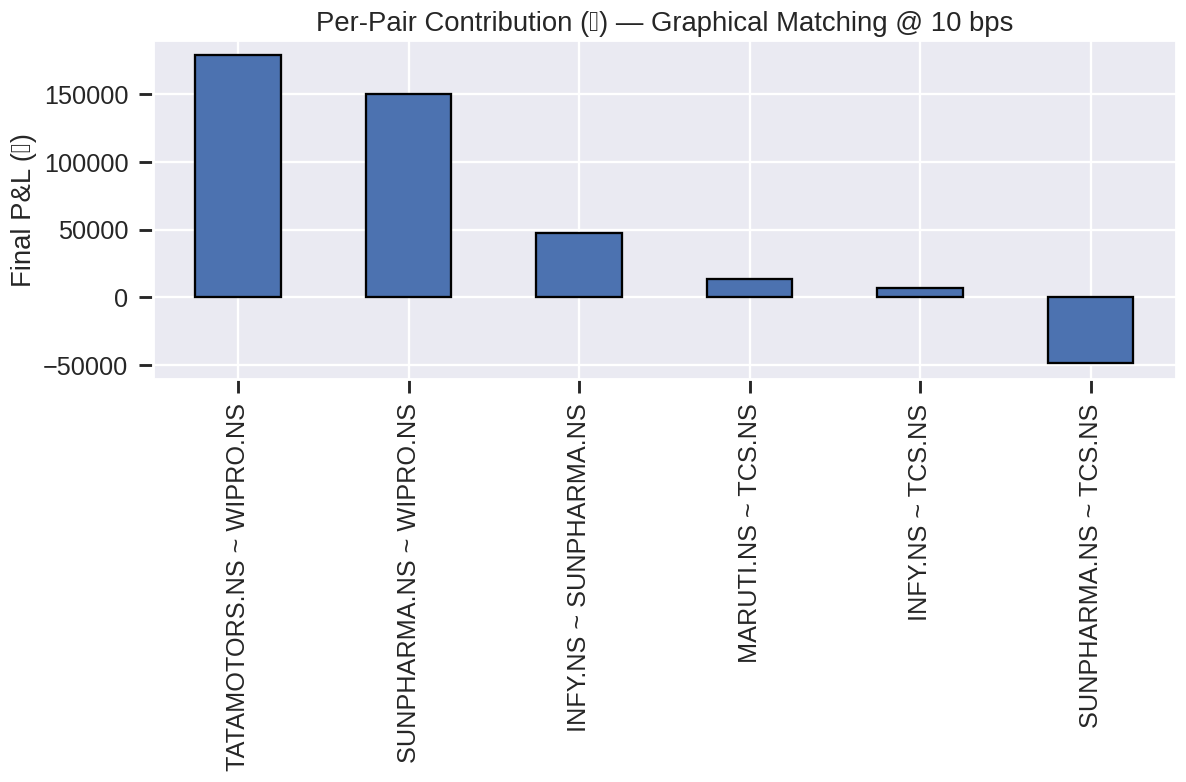

In [ ]:
# Choose the headline method for the report: prefer Matching if available, else Baseline
headline_cost = 10.0
chosen_method = None
chosen_obj = None
if 'matching_res' in globals() and matching_res is not None:
    chosen_method = "Graphical Matching"
    chosen_obj = matching_res
elif 'baseline_res' in globals() and baseline_res is not None:
    chosen_method = "Baseline Top-N"
    chosen_obj = baseline_res

if chosen_obj is None:
    print("No headline method available. Ensure previous cells produced either baseline_res or matching_res.")
else:
    print(f"Headline Method: {chosen_method} @ {headline_cost:.0f} bps")
    display(chosen_obj["stats"].style.format({
        "Final_NAV":"{:.3f}","CAGR":"{:.2%}","Vol_Ann":"{:.2%}","Sharpe":"{:.2f}",
        "MaxDD":"{:.2%}","Final_PnL_₹":"{:,.0f}","Total_Alloc_₹":"{:,.0f}"
    }).set_caption("Headline Portfolio — Core Statistics"))

    # Yearly stats
    yearly_tbl = yearly_performance(chosen_obj["nav"])
    display(yearly_tbl.style.format({
        "Return":"{:.2%}","Vol_Ann":"{:.2%}","Sharpe":"{:.2f}","MaxDD":"{:.2%}"
    }).set_caption("Yearly Breakdown"))

    # Rolling stats
    dr = chosen_obj["daily_returns"]
    rs_12m = (dr.rolling(252).mean() / dr.rolling(252).std()) * np.sqrt(252)
    dd = chosen_obj["nav"] / chosen_obj["nav"].cummax() - 1.0

    fig, ax = plt.subplots(figsize=(12,4))
    chosen_obj["nav"].plot(ax=ax, lw=1.6)
    ax.set_title(f"{chosen_method} NAV @ {headline_cost:.0f} bps")
    ax.set_ylabel("NAV")
    plt.show()

    fig, ax = plt.subplots(figsize=(12,3))
    rs_12m.plot(ax=ax, lw=1.3)
    ax.axhline(0, color="black", lw=1)
    ax.set_title("12M Rolling Sharpe")
    plt.show()

    fig, ax = plt.subplots(figsize=(12,3))
    dd.plot(ax=ax, lw=1.3, color="tab:red")
    ax.set_title("Drawdown")
    ax.set_ylabel("DD")
    plt.show()

    # Contributions for the chosen method (recompute on same cost to ensure alignment)
    # If chosen method is matching, rebuild contrib from matching run; else baseline.
    contrib_df = None
    if chosen_method == "Graphical Matching":
        contrib_df = portfolio_results[headline_cost]["contrib"] if 'portfolio_results' in globals() and headline_cost in portfolio_results else None
        # Fallback: rebuild via run_portfolio on matching_pairs only
        if contrib_df is None and 'matching_pairs' in globals():
            contrib_df = run_portfolio(prices, matching_pairs, alloc_rupees_per_pair=200_000.0,
                                       cost_bps_list=(headline_cost,), entry_z=2.0, exit_z=0.0, stop_z=3.0, lookback=60)[headline_cost]["contrib"]
    else:
        contrib_df = portfolio_results[headline_cost]["contrib"] if 'portfolio_results' in globals() and headline_cost in portfolio_results else None

    if contrib_df is not None and not contrib_df.empty:
        contrib_df = contrib_df.copy()
        contrib_df["pair"] = contrib_df["y"] + " ~ " + contrib_df["x"]
        contrib_bar = contrib_df.set_index("pair")["final_pnl_₹"].sort_values(ascending=False)

        ax = contrib_bar.plot(kind="bar", figsize=(12,4), edgecolor="black")
        ax.set_title(f"Per-Pair Contribution (₹) — {chosen_method} @ {headline_cost:.0f} bps")
        ax.set_ylabel("Final P&L (₹)")
        ax.set_xlabel("")
        plt.tight_layout()
        plt.show()
    else:
        print("Contribution table not available for the chosen method.")


In [ ]:
import os

out_dir = "outputs_pairs_project_2019_2021"
os.makedirs(out_dir, exist_ok=True)

# Save core tables if present
def safe_csv(df, path):
    try:
        if df is not None and not df.empty:
            df.to_csv(path, index=True)
            print("Saved:", path)
    except Exception as e:
        print("Skip save (", path, "):", e)

# Baseline / matching comparison (Cell 17)
if 'comp' in globals():
    safe_csv(comp, os.path.join(out_dir, "baseline_vs_matching_stats_10bps.csv"))

# Cost sweeps (Cell 20)
if 'baseline_cost_tbl' in globals() and baseline_cost_tbl is not None:
    safe_csv(baseline_cost_tbl, os.path.join(out_dir, "baseline_cost_sweep.csv"))
if 'matching_cost_tbl' in globals() and matching_cost_tbl is not None:
    safe_csv(matching_cost_tbl, os.path.join(out_dir, "matching_cost_sweep.csv"))

# Sector tables (Cells 13–15)
if 'sector_selected_all' in globals():
    safe_csv(sector_selected_all, os.path.join(out_dir, "sector_selected_pairs.csv"))
if 'sector_stats_all' in globals():
    safe_csv(sector_stats_all, os.path.join(out_dir, "sector_stats_10bps.csv"))

# Train/Test (Cell 19)
if 'tt_sel' in globals() and tt_sel is not None:
    safe_csv(tt_sel, os.path.join(out_dir, "train_selected_pairs.csv"))
if 'tt_res' in globals() and tt_res is not None:
    safe_csv(tt_res["stats"], os.path.join(out_dir, "train_test_stats_2021_10bps.csv"))

# Headline method artifacts (Cell 21)
if 'chosen_obj' in globals() and chosen_obj is not None:
    # Yearly and rolling series
    chosen_yearly = yearly_performance(chosen_obj["nav"])
    safe_csv(chosen_yearly, os.path.join(out_dir, "headline_yearly.csv"))

    dr = chosen_obj["daily_returns"]
    rs_6m = (dr.rolling(126).mean() / dr.rolling(126).std()) * np.sqrt(252)
    rs_12m = (dr.rolling(252).mean() / dr.rolling(252).std()) * np.sqrt(252)
    dd = chosen_obj["nav"] / chosen_obj["nav"].cummax() - 1.0

    pd.DataFrame({
        "daily_ret": dr,
        "rolling_sharpe_6m": rs_6m,
        "rolling_sharpe_12m": rs_12m,
        "drawdown": dd
    }).to_csv(os.path.join(out_dir, "headline_rolling_series.csv"))
    print("Saved:", os.path.join(out_dir, "headline_rolling_series.csv"))

# Save a minimal executive summary text file
summary_lines = []
summary_lines.append("Pairs Trading on NSE (2019–2021) — Executive Summary")
summary_lines.append("Signals: |z|≥2 entry, exit at mean, stop at 3σ; lookback 60 days; equal ₹ allocation per pair.")
if 'comp' in globals():
    try:
        best_row = comp.loc["Graphical Matching"] if "Graphical Matching" in comp.index else comp.iloc[0]
        summary_lines.append(f"Headline Method: {best_row.name} @10 bps")
        summary_lines.append(f"CAGR: {best_row['CAGR']:.2%}, Sharpe: {best_row['Sharpe']:.2f}, MaxDD: {best_row['MaxDD']:.2%}, Final NAV: {best_row['Final_NAV']:.3f}")
    except Exception:
        pass
open(os.path.join(out_dir, "executive_summary.txt"), "w").write("\n".join(summary_lines))
print("Saved:", os.path.join(out_dir, "executive_summary.txt"))

print("\nExport complete. Files in:", out_dir)


Saved: outputs_pairs_project_2019_2021/baseline_vs_matching_stats_10bps.csv
Saved: outputs_pairs_project_2019_2021/baseline_cost_sweep.csv
Saved: outputs_pairs_project_2019_2021/matching_cost_sweep.csv
Saved: outputs_pairs_project_2019_2021/sector_selected_pairs.csv
Saved: outputs_pairs_project_2019_2021/sector_stats_10bps.csv
Saved: outputs_pairs_project_2019_2021/train_selected_pairs.csv
Saved: outputs_pairs_project_2019_2021/train_test_stats_2021_10bps.csv
Saved: outputs_pairs_project_2019_2021/headline_yearly.csv
Saved: outputs_pairs_project_2019_2021/headline_rolling_series.csv
Saved: outputs_pairs_project_2019_2021/executive_summary.txt

Export complete. Files in: outputs_pairs_project_2019_2021
